# PyTorch Module of Maximum Entropy Method (MEM)
[link](https://docs.google.com/document/d/1SUVFs1Uzil_yPEEaPSdtv-UNS_TNVRtd/edit)

Using Lagrange Multiplier method to maximize the information entropy. Using PyTorch and gradient descent to optimize the x-ray scattering data. Compared with conventional Fourier Transformation Approach, the MEM needs much fewer data and more robust to the noise.


### Backgrounds

Under Xray diffractormeter, the measured intensity can be described as the following form:
$$\begin{aligned}
I(\mathbf{Q}) = \int_0^\infty \langle f(\mathbf{Q}) \rangle^2 (\rho(r) - \rho_0) \frac{\sin(\mathbf{Q}r)}{\mathbf{Q}r} d r + \langle f(\mathbf{Q})^2 \rangle
\end{aligned}$$, 
where $\mathbf{Q} = \frac{4 \pi \sin \theta}{\lambda}$ is a variable of diffraction angle $\theta$ and Xray wavelength $\lambda$, $\langle \rangle$ stands for the mean of the who sample, $f(\mathbf{Q})$ stands for the scattering factor of an atom along vector $\mathbf{Q}$, $r$ is the radius of a spheric shell, $\rho{r}$ is the atom density in this shell, and $\rho_0$ is the average density of the sample.

Since $f$ is also a variable of the atom types (i.e. Oxygen is different from Carbon), so the structure factor $S(\mathbf{Q})$ is defined by ignoring the different types of atoms and keeping the geometeric relations among atoms.
$$\begin{aligned}
S(\mathbf{Q}) = \int_0^\infty (\rho(r) - \rho_0) \frac{\sin(\mathbf{Q}r)}{\mathbf{Q}r} d r + 1
\end{aligned}$$

To solve the $\rho(r)$, we can Fourier transform $Q(S(\mathbf{Q})-1)$. It requires many data to guarantee a good result. We can also try to use the MEM method to find $\rho(r)$ with much fewer data. Here, I successfully reconstructed $\rho(r)$ with $121$ data when it requires thousands of data for Fourier Transform method.

### Method

Shannon entropy for scattering:
$$\begin{aligned}
H = -K\sum_{i=1}^M Np_i \ln p_i
\end{aligned}$$,
where $K$ is a positive constant, $M$ is the total number of volume elements, $N$ is the total number of atomes, and $p_i$ stands for the probability of atoms in the $i_{th}$ volume element. Since a volume element $\Delta V = 4 \pi r^2 \Delta r$, we thus have 
$$\begin{aligned}
H = -K'\sum_{i=1}^M 4 \pi r_i^2 \Delta r \rho(r_i) \ln \rho(r_i)
\end{aligned}$$,

The objective is 
$$\begin{aligned}
\underset{\rho(r)}{\text{argmax}} &\quad H\\
\text{s.t.} &\quad S(\mathbf{Q}_s) - 1 = \sum_{i=1}^M 4\pi r_i^2 \Delta r (\rho(r_i) - \rho_0) \frac{\sin(\mathbf{Q}_s r_i)}{\mathbf{Q}_sr_i}\\
&\quad \sum_{i=1}^M 4\pi r_i^2 \Delta r (\rho(r_i) - \rho_0) = 0
\end{aligned}$$.
The first constraint is from the the scattered intensity and the second constraint is from the the fact that $\sum_{i=1}^M 4\pi r_i^2 \Delta r \rho(r_i) = N = \sum_{i=1}^M 4\pi r_i^2 \Delta r  \rho_0$ where $N$ is the total number of scattering elements.

Considering Lagrange multiplier method, we define 
$$\begin{aligned}
W = \sum_{i=1}^M 4 \pi r_i^2  \rho(r_i) \ln \rho(r_i) - \lambda_0 \sum_{i=1}^M 4\pi r_i^2 (\rho(r_i) - \rho_0) - \sum_{s=1} \lambda_s \left[ \sum_{i=1}^M 4\pi r_i^2  (\rho(r_i) - \rho_0) \frac{\sin(\mathbf{Q}_s r_i)}{\mathbf{Q}_sr_i} - D_s \right]
\end{aligned}$$,
and thus $\rho(r_i) = \exp\left[-1 - \lambda_0 - \sum_{s=1}^T \lambda_s \frac{\sin(\mathbf{Q}_s r_i)}{\mathbf{Q}_sr_i} \right]$ to maximize the $W$. $T$ is the total number of data or $\mathbf{Q}$.

We can find $\rho(r_i)$ by solving the $\lambda_0$ and $\lambda_s$. I use gradient descent and PyTorch to solve this problem. So the error comes from two aspects:
1. $\|\sum_{i=1}^M 4\pi r_i^2 \left( \exp\left[-1 - \lambda_0 - \sum_{s=1}^T \lambda_s \frac{\sin(\mathbf{Q}_s r_i)}{\mathbf{Q}_sr_i} \right] - \rho_0 \right)\|$
1. $\| \sum_{i=1}^M 4\pi r_i^2 \left( \exp\left[-1 - \lambda_0 - \sum_{s=1}^T \lambda_s \frac{\sin(\mathbf{Q}_s r_i)}{\mathbf{Q}_sr_i} \right] - \rho_0 \right) \frac{\sin(\mathbf{Q}_s r_i)}{\mathbf{Q}_sr_i} - D_s \|$
.

Since we have $T$ data, we have $T$ indepedent constraints for the second one ($T+1$ in total). What I will do is to calculate the sum of there errors and use it for backpropgation and optimize $\lambda_0$ and $\lambda_s$.

---
Notes:
* $D_s = \frac{S(Q) - 1}{\Delta r}$ where $\Delta r$ is defined by the user.

In [ ]:
if __name__ == '__main__': 
    %reset -f

In [ ]:
import numpy as np
import torch, torch.nn as nn
from torch.nn.parameter import Parameter, UninitializedParameter
import matplotlib.pyplot as plt

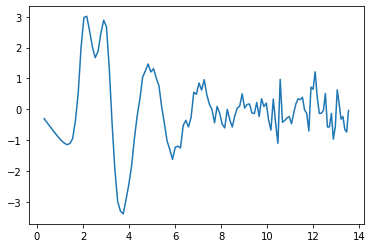

In [ ]:
data = torch.load('water.pt');
Qs = data['Qs']; Ds = data['Ds'];
plt.figure();
plt.plot(Qs,Ds);
plt.show()

In [ ]:
Rmin = 1; Rmax = 10;
Rs = torch.arange(100).reshape(-1,1);
Rs = Rs - Rs.min();
Rs = Rs / Rs.max();
Rs = Rs * (Rmax-Rmin) + Rmin;
delta_r = (Rs[1:] - Rs[:-1]).mean();
Ds = Ds / delta_r; ## this is essential, DS is discrete

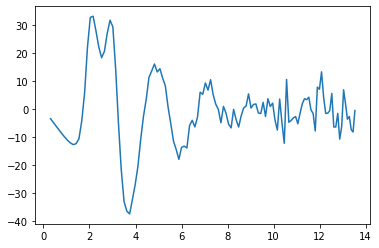

In [ ]:
plt.figure();
plt.plot(Qs,Ds);
plt.show()

In [ ]:
class Rho(nn.Module):
    def __init__(self, Qs, Ds, Rs, rho0):
        super(Rho, self).__init__();
        self.lambda0 = Parameter(torch.randn(1, requires_grad=True)/100);
        self.lambdas = Parameter(torch.randn(Qs.shape, requires_grad=True)/100);
#         Qr = Qs @ Rs.T; # N x M
        
        self.Qs = Parameter(Qs.float(), requires_grad=False); 
        self.Rs = Parameter(Rs.float(), requires_grad=False); 
        self.Ds = Parameter(Ds.float(), requires_grad=False); self.rho0 = Parameter(torch.tensor(rho0).float(), requires_grad=False);
        self.Qr = Parameter(self.Qs @ self.Rs.T, requires_grad=False);  
        self.QrTerm = Parameter(torch.sin(self.Qr)/self.Qr, requires_grad=False);
    
        
    def forward(self):
        logrho = -1 - self.lambda0 - torch.sin(self.Qr)/self.Qr * self.lambdas.repeat(1, self.Qr.shape[1])
        self.rho = torch.exp(logrho).sum(dim=0);
#         self.rho = (torch.clone(self.Rs));
#         for kr in range(Rs.shape[0]):
#             Qr = self.Qs * self.Rs[kr,0];
#             logrho = -1 - self.lambda0 + (torch.sin(Qr)/Qr*self.lambdas).sum();
#             self.rho[kr] = torch.exp(logrho);
        
        loss0 = torch.sum((4*torch.pi*self.Rs.T**2 * (self.rho - self.rho0)).T**2);
#         print(self.lambda0.grad, self.lambdas.grad)
        loss = torch.sum((4*torch.pi*self.Rs.T**2 * (self.rho - self.rho0).T * self.QrTerm - self.Ds)**2, dim=1);
        N = loss.shape[0];
        return (loss0 + loss.sum()) / (N+1);   

In [ ]:
rho0 = 1e3 * 1e3 / 18 * 6.02e23 / 1e30
MEM = Rho(Qs, Ds, Rs, rho0)

In [ ]:
devicename = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(devicename);
MEM = MEM.to(device);

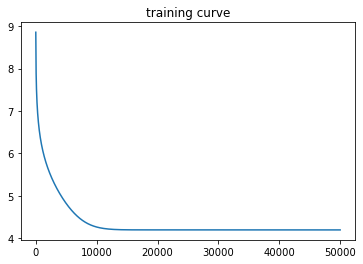

In [ ]:
lr = 3e-2;
epochs = 50000;
losses = []
# optimizer = torch.optim.SGD(rhos.parameters(), lr=lr, momentum=0.9);
optimizer = torch.optim.Adam(MEM.parameters(), lr=lr);
for epoch in range(epochs):
    this_loss = MEM();
    optimizer.zero_grad();
    this_loss.backward();
    optimizer.step();
    losses.append(this_loss.detach().to('cpu'));
#     print(this_loss)
plt.figure()
plt.plot(np.log10(losses))
plt.title('training curve')
plt.show()

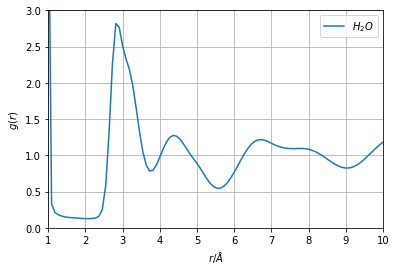

In [ ]:
rho = MEM.rho.detach().to('cpu').numpy()
r = Rs.detach().to('cpu').numpy()
plt.figure(facecolor='w')
# plt.plot(r, 4 * np.pi * r.reshape(-1,) * (rho - rho0), label='${H_2O}$')
plt.plot(r, rho / rho0, label='${H_2O}$')
plt.xlabel('$r/\AA$');
plt.ylabel('$g(r)$');
plt.legend();
plt.xticks(np.arange(Rmin, Rmax+1, 1))
plt.grid();
plt.ylim(0,3);
plt.xlim(1,10);
plt.show()

Ground true:

Greg Hura et.al J. Chem. Phys. 113, 9140 (2000); https://doi.org/10.1063/1.1319614


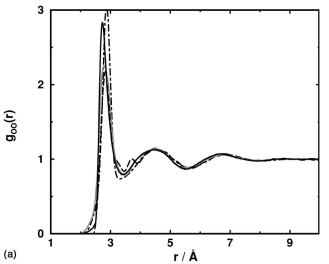